In [1]:
import pandas as pd
import numpy as np
import timm
import torchvision.transforms as T
import torch
import itertools
from torch.optim import SGD
import os

from wildlife_tools.train import ArcFaceLoss, BasicTrainer, set_seed
from wildlife_tools.features import DeepFeatures
from wildlife_tools.data import ImageDataset, SafeImageDataset


/home/users/dash/guppies/embeddings/wildlife-tools/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# Load metadata
PT_CSV = '/home/users/dash/guppies/embeddings/wildlife-tools/exploring/csvs/top_30000_individuals_database.csv'
PT_images = '/gws/nopw/j04/iecdt/dash/cropped_images/id/w_random_masks'
PT_storage = '/gws/nopw/j04/iecdt/dash/embeddings/models'
df = pd.read_csv(PT_CSV)
# df['path'] = df['path'].str.replace('.JPG', '.png', case=False)
# df.to_csv(PT_CSV, index=False)
df.head()

,identity,path,date
0,1750,1206/Lower LaLaja/28a/DCIM/100NCD90/DSC_0012.png,2012-06-28
1,1750,1207/Lower Lalaja/29b/DCIM/100NCD60/DSC_4746.png,2012-07-29
2,1750,1208/Lower Lalaja/27B/100NCD90/DSC_0153.png,2012-08-27
3,5003,1208/Upper Lalaja/2B/100NCD90/DSC_0157.png,2012-09-02
4,5003,1209/Upper Lalaja/3B/100NCD90/DSC_0099.png,2012-10-03


In [3]:
import pynvml

pynvml.nvmlInit()
device_count = torch.cuda.device_count()
max_free_mem = 0
best_device = 0

for i in range(device_count):
    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    if mem_info.free > max_free_mem:
        max_free_mem = mem_info.free
        best_device = i

device = torch.device(f'cuda:{best_device}')
print(f'using gpu {device} out of {torch.cuda.device_count()}')

using gpu cuda:1 out of 4


In [4]:

# Define image transformations
transform = T.Compose([
    T.Resize((224, 224)),  # Resize to match MegaDescriptor-L-384 input
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create ImageDataset
database_dataset = SafeImageDataset(df, root=PT_images, transform=transform, log_file='unreadable_images.txt')

In [5]:
# Load the MegaDescriptor model
# backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-L-384', pretrained=True, num_classes=0)
backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', pretrained=True, num_classes=0)


In [6]:
save_path = '/gws/nopw/j04/iecdt/dash/embeddings/models/MGD/MGD_30000ids_arcface/model_epoch_10.pt/checkpoint.pth'
checkpoint = torch.load(save_path, map_location=device, weights_only=False)
print(checkpoint.keys())

dict_keys(['model', 'objective', 'optimizer', 'epoch', 'rng_states'])


In [7]:
backbone.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:

extractor = DeepFeatures(backbone, device=device)

# Extract features
features = extractor(database_dataset)


 69%|███████████████████████████████████████▊                  | 807/1174 [1:06:59<28:58,  4.74s/it]

In [ ]:
assert len(features) == len(database_dataset)
assert tuple(features.features.shape) == (len(database_dataset), 768)

In [ ]:
# Convert embeddings to NumPy array
embeddings = features.features
if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.detach().cpu().numpy()

# Extract labels
labels = features.labels_string  # Assuming labels are stored here

In [ ]:
# Save embeddings and labels to an NPZ file
import os
import numpy as np

# Define save path
save_dir = '/gws/nopw/j04/iecdt/dash/embeddings/models/MGD/MGD_30000ids_arcface/model_epoch_10.pt/'
save_file = os.path.join(save_dir, 'top_30000_ids_database_embeddings.npz')

# Ensure directory exists
os.makedirs(save_dir, exist_ok=True)

# Save both embeddings and labels in a single NPZ file
np.savez(save_file, 
         embeddings=embeddings,
         labels=labels)

print(f"Embeddings and labels saved to {save_file}")

In [ ]:
# To load the data later:
loaded_data = np.load('/gws/nopw/j04/iecdt/dash/embeddings/models/MGD/MGD_30000ids_arcface/model_epoch_10.pt/top_30000_ids_database_embeddings.npz')
embeddings = loaded_data['embeddings']
labels = loaded_data['labels']

In [29]:
print(labels[:10])  # Print first 10 labels for verification
print(len(set(labels))) #number of individuals
print(embeddings.shape)

['63498' '63498' '63498' '63498' '63498' '63498' '63498' '63498' '63498'
 '63498']
10
(243, 768)


In [17]:
from sklearn.manifold import TSNE

# Determine the number of samples
n_samples = embeddings.shape[0]

# Set perplexity to a value less than n_samples
perplexity_value = min(5, n_samples - 1)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(embeddings)


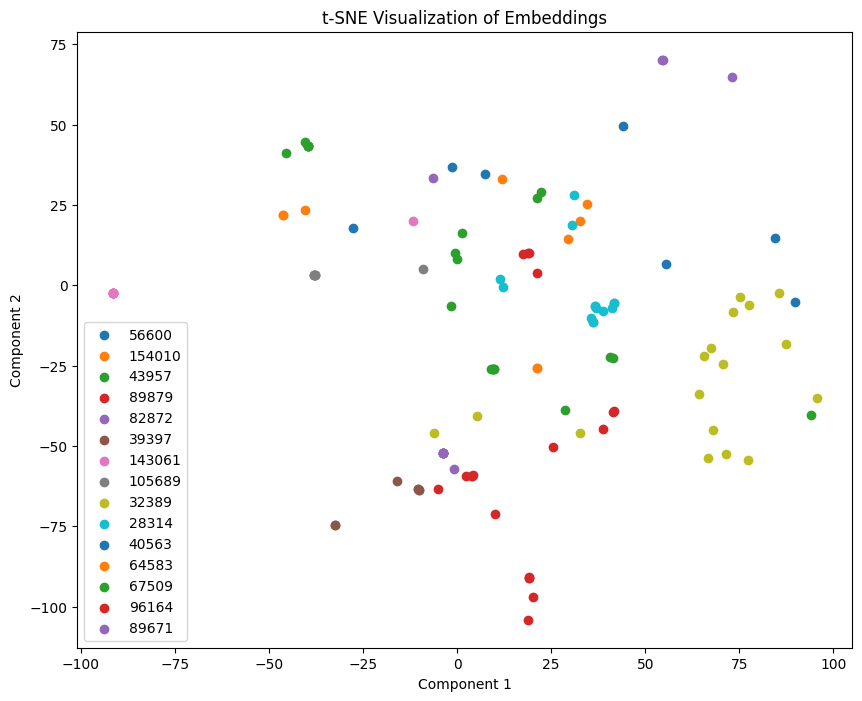

In [23]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(10, 8))
unique_labels = set(labels)

# for label in unique_labels:
#     indices = [i for i, l in enumerate(labels) if l == label]
#     plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label)

random_labels = random.sample(list(unique_labels), 15)

for label in random_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label)

plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [24]:
from wildlife_tools.similarity import CosineSimilarity
from wildlife_tools.inference import KnnClassifier
import numpy as np



# Extract features
query_features = extractor(query_dataset)
database_features = features
# database_features = extractor(database_dataset)

# Compute cosine similarity
similarity_function = CosineSimilarity()
similarity = similarity_function(query_features, database_features)

# Perform 1-NN classification
classifier = KnnClassifier(k=1, database_labels=database_dataset.labels_string)
predictions = classifier(similarity)

# Evaluate accuracy
accuracy = np.mean(np.array(query_dataset.labels_string) == np.array(predictions))
print(f'1-NN Classification Accuracy: {accuracy:.2%}')


100%|█████████████████████████████████████████████████████████████| 260/260 [25:20<00:00,  5.85s/it]


1-NN Classification Accuracy: 37.31%


In [ ]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(embeddings)
# Initialize dictionaries to hold similarities
same_identity_sims = defaultdict(list)
different_identity_sims = defaultdict(list)

num_embeddings = len(embeddings)

for i in range(num_embeddings):
    for j in range(i + 1, num_embeddings):
        sim = similarity_matrix[i][j]
        if labels[i] == labels[j]:
            same_identity_sims[labels[i]].append(sim)
        else:
            key = f"{labels[i]} vs {labels[j]}"
            different_identity_sims[key].append(sim)

# Compute average similarities
avg_same_identity_sim = np.mean([np.mean(sims) for sims in same_identity_sims.values()])
avg_different_identity_sim = np.mean([np.mean(sims) for sims in different_identity_sims.values()])

print(f"Average similarity within the same identity: {avg_same_identity_sim:.4f}")
print(f"Average similarity between different identities: {avg_different_identity_sim:.4f}")

In [16]:
print(same_identity_sims.values())
print(different_identity_sims.values())

dict_values([[np.float32(0.6974768), np.float32(0.09702696), np.float32(0.87976694), np.float32(0.94433403), np.float32(0.13532045), np.float32(0.7862973), np.float32(0.9256374), np.float32(0.5699037), np.float32(0.6326706), np.float32(0.8611397), np.float32(0.88750315), np.float32(0.9132253), np.float32(0.9494519), np.float32(0.20080546), np.float32(0.7701068), np.float32(0.7697402), np.float32(0.8927848), np.float32(0.5951601), np.float32(0.7687601), np.float32(0.75620735), np.float32(0.7626793), np.float32(0.9081795), np.float32(0.8850136), np.float32(0.74874485), np.float32(0.87047017), np.float32(0.9114697), np.float32(0.6578307), np.float32(0.8842803), np.float32(0.9400009), np.float32(0.10583155), np.float32(0.82868147), np.float32(0.9161985), np.float32(0.6572112), np.float32(0.22914809), np.float32(0.7534605), np.float32(0.71426976), np.float32(0.19606319), np.float32(0.60475373), np.float32(0.70241904), np.float32(0.66581476), np.float32(0.6424886), np.float32(0.71664214), np

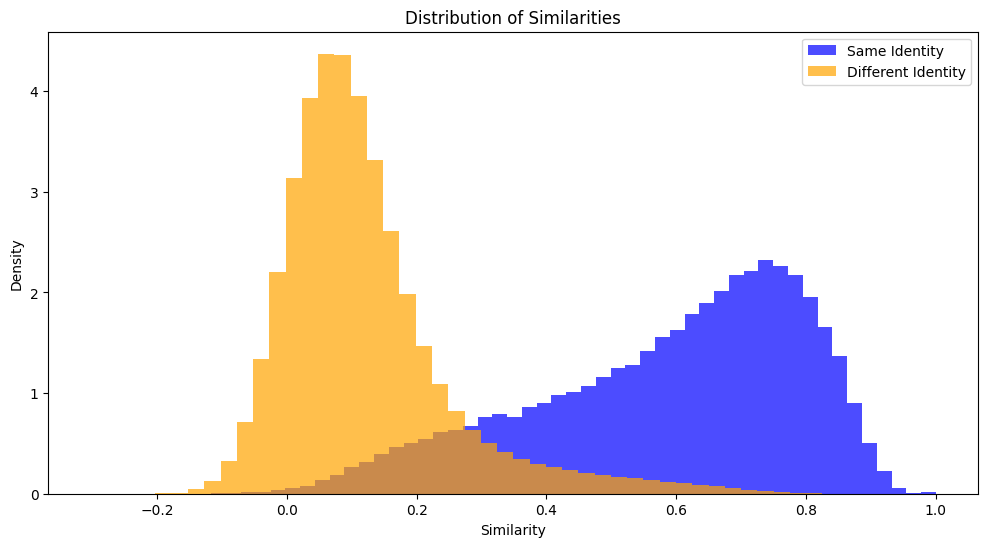

In [ ]:
plt.figure(figsize=(12, 6))

# Flatten the lists of similarities
same_identity_flat = [sim for sims in same_identity_sims.values() for sim in sims]
different_identity_flat = [sim for sims in different_identity_sims.values() for sim in sims]

# Plot histograms
plt.hist(same_identity_flat, bins=50, alpha=0.7, label='Same Identity', color='blue', density=True)
plt.hist(different_identity_flat, bins=50, alpha=0.7, label='Different Identity', color='orange', density=True)

# Add labels and legend
plt.title('Distribution of Similarities')
plt.xlabel('Similarity')
plt.ylabel('Density')
plt.legend()

plt.show()